In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Tensorflow
import tensorflow as tf
print('Tested with TensorFlow 1.2.0')
print('Your TensorFlow version:', tf.__version__) 

# Feeding function for enqueue data
from tensorflow.python.estimator.inputs.queues import feeding_functions as ff

# Rnn common functions
from tensorflow.contrib.learn.python.learn.estimators import rnn_common

# Run an experiment
from tensorflow.contrib.learn.python.learn import learn_runner

# Model builder
from tensorflow.python.estimator import model_fn as model_fn_lib

# Plot images with pyplot
%matplotlib inline
from matplotlib import pyplot as plt

# Helpers for data processing
import pandas as pd
import numpy as np
import argparse

Tested with TensorFlow 1.2.0
Your TensorFlow version: 1.2.0


In [2]:
# Data files
TRAIN_INPUT = 'data/train.csv'
TEST_INPUT = 'data/test.csv'
MY_TEST_INPUT = 'data/mytest.csv'

# Parameters for training
BATCH_SIZE = 64

# Parameters for data processing
VOCAB_SIZE = 256
CHARACTERS = [chr(i) for i in range(VOCAB_SIZE)]
SEQUENCE_LENGTH_KEY = 'sequence_length'
COLOR_NAME_KEY = 'color_name'

In [3]:
# Returns the column values from a CSV file as a list
def _get_csv_column(csv_file, column_name):
    with open(csv_file, 'r') as f:
        df = pd.read_csv(f)
        return df[column_name].tolist()

# Plots a color image
def _plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

In [4]:
def get_input_fn(csv_file, batch_size, num_epochs=1, shuffle=True):
    def _parse(line):
        # each line: name, red, green, blue
        # split line
        items = tf.string_split([line],',').values

        # get color (r, g, b)
        color = tf.string_to_number(items[1:], out_type=tf.float32) / 255.0

        # split color_name into a sequence of characters
        color_name = tf.string_split([items[0]], '')
        length = color_name.indices[-1, 1] + 1 # length = index of last char + 1
        color_name = color_name.values
        
        return color, color_name, length

    def _length_bin(length, cast_value=5, max_bin_id=10):
        '''
        Chooses a bin for a word given it's length.
        The goal is to use group_by_window to group words
        with the ~ same ~ length in the same bin.

        Each bin will have the size of a batch, so it can train faster.
        '''
        bin_id = tf.cast(length / cast_value, dtype=tf.int64)
        return tf.minimum(bin_id, max_bin_id)

    def _pad_batch(ds, batch_size):
        return ds.padded_batch(batch_size, 
                               padded_shapes=([None], [None], []),
                               padding_values=(0.0, chr(0), tf.cast(0, tf.int64)))

    def input_fn():
        # https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/data
        dataset = (
            tf.contrib.data.TextLineDataset(csv_file) # reading from the HD
            .skip(1) # skip header
            .repeat(num_epochs) # repeat dataset the number of epochs
            .map(_parse) # parse text to variables
            .group_by_window(key_func=lambda color, color_name, length: _length_bin(length), # choose a bin
                             reduce_func=lambda key, ds: _pad_batch(ds, batch_size), # apply reduce funtion
                             window_size=batch_size)
        )
        
        # for our "manual" test we don't want to shuffle the data
        if shuffle:
            dataset = dataset.shuffle(buffer_size=100000)

        # create iterator
        color, color_name, length = dataset.make_one_shot_iterator().get_next()

        features = {
            COLOR_NAME_KEY: color_name,
            SEQUENCE_LENGTH_KEY: length,
        }

        return features, color
    return input_fn

In [5]:
train_input_fn = get_input_fn(TRAIN_INPUT, BATCH_SIZE)
test_input_fn = get_input_fn(TEST_INPUT, BATCH_SIZE)

In [6]:
x, y = get_input_fn(TRAIN_INPUT, 1)()

with tf.Session() as s:
    print(s.run(x))
    print(s.run(y))

{'color_name': array([[b'b', b'l', b'o', b'o', b'd', b' ', b'r', b'e', b'd']], dtype=object), 'sequence_length': array([9])}
[[ 0.37254903  0.61960787  0.627451  ]]


In [7]:
def get_model_fn(rnn_cell_sizes,
                 label_dimension,
                 dnn_layer_sizes=[],
                 optimizer='SGD',
                 learning_rate=0.01):
    
    def model_fn(features, labels, mode):
        
        color_name = features[COLOR_NAME_KEY]
        sequence_length = tf.cast(features[SEQUENCE_LENGTH_KEY], dtype=tf.int32) # int64 -> int32
        
        # ----------- Preparing input --------------------
        # Creating a tf constant to hold the map char -> index
        mapping = tf.constant(CHARACTERS, name="mapping")
        table = tf.contrib.lookup.index_table_from_tensor(mapping, dtype=tf.string)
        int_color_name = table.lookup(color_name)
        
        # converting color names to one hot representation
        color_name_onehot = tf.one_hot(int_color_name, depth=len(CHARACTERS) + 1)
        
        # ---------- RNN -------------------
        # Each RNN layer will consist of a LSTM cell
        rnn_layers = [tf.nn.rnn_cell.LSTMCell(size) for size in rnn_cell_sizes]
        
        # Construct the layers
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        
        # Runs the RNN model dynamically
        # more about it at: 
        # https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
        outputs, final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                                 inputs=color_name_onehot,
                                                 sequence_length=sequence_length,
                                                 dtype=tf.float32)

        # Slice to keep only the last cell of the RNN
        last_activations = rnn_common.select_last_activations(outputs,
                                                              sequence_length)

        # ------------ Dense layers -------------------
        # Construct dense layers on top of the last cell of the RNN
        for units in dnn_layer_sizes:
            last_activations = tf.layers.dense(
              last_activations, units, activation=tf.nn.relu)
        
        # Final dense layer for prediction
        predictions = tf.layers.dense(last_activations, label_dimension)

        # ----------- Loss and Optimizer ----------------
        loss = None
        train_op = None

        if mode != tf.estimator.ModeKeys.PREDICT:    
            loss = tf.losses.mean_squared_error(labels, predictions)
    
        if mode == tf.estimator.ModeKeys.TRAIN:    
            train_op = tf.contrib.layers.optimize_loss(
              loss,
              tf.contrib.framework.get_global_step(),
              optimizer=optimizer,
              learning_rate=learning_rate)
        
        return model_fn_lib.EstimatorSpec(mode,
                                           predictions=predictions,
                                           loss=loss,
                                           train_op=train_op)
    return model_fn

In [8]:
model_fn = get_model_fn(rnn_cell_sizes=[256, 128], # size of the hidden layers
                        label_dimension=3, # since is RGB
                        dnn_layer_sizes=[128], # size of units in the dense layers on top of the RNN
                        optimizer='Adam', # changing optimizer to Adam
                        learning_rate=0.01)

estimator = tf.estimator.Estimator(model_fn=model_fn, model_dir='colorbot')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'colorbot', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}


In [9]:
NUM_EPOCHS = 40
for i in range(NUM_EPOCHS):
    print('Training epoch %d' % i)
    print('-' * 20)
    estimator.train(input_fn=train_input_fn)
    print('Evaluating epoch %d' % i)
    print('-' * 20)
    estimator.evaluate(input_fn = test_input_fn)

Training epoch 0
--------------------


/Users/taocheng/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-4572
INFO:tensorflow:Saving checkpoints for 4573 into colorbot/model.ckpt.
INFO:tensorflow:loss = 0.00568408, step = 4573
INFO:tensorflow:Saving checkpoints for 4595 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00526464.
Evaluating epoch 0
--------------------
INFO:tensorflow:Starting evaluation at 2017-07-15-17:55:42
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-4595
INFO:tensorflow:Finished evaluation at 2017-07-15-17:55:43
INFO:tensorflow:Saving dict for global step 4595: global_step = 4595, loss = 0.0534455
Training epoch 1
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-4595
INFO:tensorflow:Saving checkpoints for 4596 into colorbot/model.ckpt.
INFO:tensorflow:loss = 0.00846301, step = 4596
INFO:tensorflow:Saving checkpoints for 4618 into colorbot/model.ckpt.
INFO:

INFO:tensorflow:Saving dict for global step 4848: global_step = 4848, loss = 0.0448706
Training epoch 12
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-4848
INFO:tensorflow:Saving checkpoints for 4849 into colorbot/model.ckpt.
INFO:tensorflow:loss = 0.00283283, step = 4849
INFO:tensorflow:Saving checkpoints for 4871 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.000136655.
Evaluating epoch 12
--------------------
INFO:tensorflow:Starting evaluation at 2017-07-15-18:00:00
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-4871
INFO:tensorflow:Finished evaluation at 2017-07-15-18:00:01
INFO:tensorflow:Saving dict for global step 4871: global_step = 4871, loss = 0.0438762
Training epoch 13
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-4871
INFO:tensorflow:Saving checkpoints for 4872 into colorbot/model

INFO:tensorflow:Starting evaluation at 2017-07-15-18:03:36
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-5124
INFO:tensorflow:Finished evaluation at 2017-07-15-18:03:37
INFO:tensorflow:Saving dict for global step 5124: global_step = 5124, loss = 0.0583523
Training epoch 24
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-5124
INFO:tensorflow:Saving checkpoints for 5125 into colorbot/model.ckpt.
INFO:tensorflow:loss = 0.00746646, step = 5125
INFO:tensorflow:Saving checkpoints for 5147 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00400408.
Evaluating epoch 24
--------------------
INFO:tensorflow:Starting evaluation at 2017-07-15-18:03:54
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-5147
INFO:tensorflow:Finished evaluation at 2017-07-15-18:03:55
INFO:tensorflow:Saving dict for global step 5147: global_step = 5147, loss = 0.0515888
Training epoch 25
-----------

INFO:tensorflow:Saving checkpoints for 5400 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.000612075.
Evaluating epoch 35
--------------------
INFO:tensorflow:Starting evaluation at 2017-07-15-18:08:08
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-5400
INFO:tensorflow:Finished evaluation at 2017-07-15-18:08:09
INFO:tensorflow:Saving dict for global step 5400: global_step = 5400, loss = 0.0403995
Training epoch 36
--------------------
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-5400
INFO:tensorflow:Saving checkpoints for 5401 into colorbot/model.ckpt.
INFO:tensorflow:loss = 0.00207411, step = 5401
INFO:tensorflow:Saving checkpoints for 5423 into colorbot/model.ckpt.
INFO:tensorflow:Loss for final step: 0.00148978.
Evaluating epoch 36
--------------------
INFO:tensorflow:Starting evaluation at 2017-07-15-18:08:26
INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-5423
INFO:tensorflo

In [10]:
# To making prediction

def predict(estimator, input_file):
    preds = estimator.predict(input_fn=get_input_fn(input_file, 1, shuffle=False))
    color_names = _get_csv_column(input_file, 'name')

    print()
    for p, name in zip(preds, color_names):
        color = tuple(map(int, p * 255))
        print(name + ',', 'rgb:', color)
        _plot_rgb(p)


INFO:tensorflow:Restoring parameters from colorbot/model.ckpt-5492
orange, rgb: (238, 135, 45)


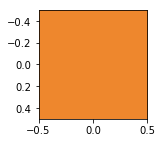

tensorflow orange, rgb: (231, 135, 67)


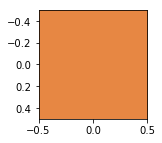

adfgasdgasd, rgb: (96, 124, 105)


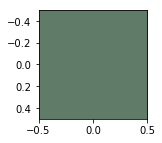

purple blue, rgb: (79, 58, 217)


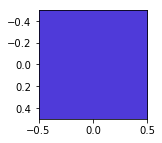

purple red, rgb: (183, 39, 90)


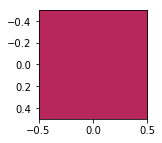

purple, rgb: (128, 18, 143)


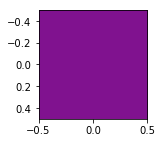

water, rgb: (200, 185, 170)


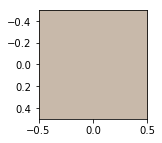

pink, rgb: (247, 189, 227)


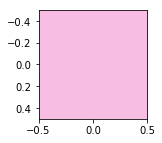

rock, rgb: (97, 111, 109)


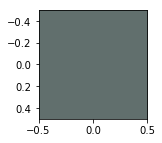

In [11]:

predict(estimator, MY_TEST_INPUT)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'pretrained', '_tf_random_seed': 1, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000}

INFO:tensorflow:Restoring parameters from pretrained/model.ckpt-8069
orange, rgb: (233, 124, 19)


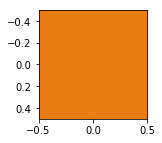

tensorflow orange, rgb: (232, 149, 88)


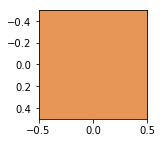

adfgasdgasd, rgb: (201, 184, 157)


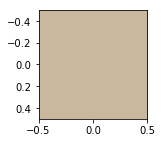

purple blue, rgb: (51, 13, 220)


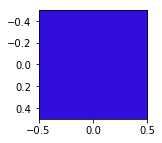

purple red, rgb: (152, 40, 61)


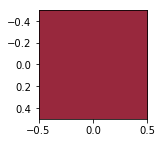

purple, rgb: (92, 23, 109)


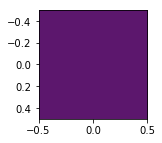

water, rgb: (160, 201, 202)


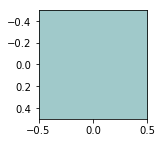

pink, rgb: (257, 153, 165)


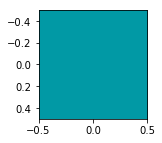

rock, rgb: (83, 65, 52)


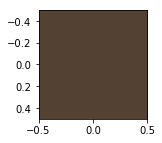

In [12]:
#Pre-train model prediction

pre_estimator = tf.estimator.Estimator(model_dir='pretrained', model_fn=model_fn)
predict(pre_estimator, MY_TEST_INPUT)

In [13]:
# small important detail, to train properly with the experiment you need to
# repeat the dataset the number of epochs desired
train_input_fn = get_input_fn(TRAIN_INPUT, BATCH_SIZE, num_epochs=40)

# create experiment
def generate_experiment_fn(run_config, hparams):
    estimator = tf.estimator.Estimator(model_fn=model_fn, config=run_config)
    return tf.contrib.learn.Experiment(
        estimator,
        train_input_fn=train_input_fn,
        eval_input_fn=test_input_fn
    )

learn_runner.run(generate_experiment_fn, run_config=tf.contrib.learn.RunConfig(model_dir='model_dir'))

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1234a3eb8>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'model_dir'}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.


/Users/taocheng/anaconda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from model_dir/model.ckpt-732
INFO:tensorflow:Saving checkpoints for 733 into model_dir/model.ckpt.
INFO:tensorflow:loss = 0.00526277, step = 733
INFO:tensorflow:Starting evaluation at 2017-07-15-18:14:36
INFO:tensorflow:Restoring parameters from model_dir/model.ckpt-733
INFO:tensorflow:Evaluation [1/100]
INFO:tensorflow:Evaluation [2/100]
INFO:tensorflow:Evaluation [3/100]
INFO:tensorflow:Evaluation [4/100]
INFO:tensorflow:Evaluation [5/100]
INFO:tensorflow:Evaluation [6/100]
INFO:tensorflow:Finished evaluation at 2017-07-15-18:14:37
INFO:tensorflow:Saving dict for global step 733: global_step = 733, loss = 0.0967104
INFO:tensorflow:Validation (step 733): loss = 0.0967104, global_step = 733
INFO:tensorflow:global_step/sec: 3.56024
INFO:tensorflow:loss = 0.0172557, step = 833 (28.089 sec)
INFO:tensorflow:global_step/sec: 4.15839
INFO:tensorflow:loss = 0.00393331, step = 933 (24.049 sec)
INFO:tensorflow:glo

({'global_step': 1464, 'loss': 0.087945201}, [])

In [14]:
def get_input_fn(csv_file, batch_size, num_epochs=1, shuffle=True):
    def _parse(line):
        # each line: name, red, green, blue
        # split line
        items = tf.string_split([line],',').values

        # get color (r, g, b)
        color = tf.string_to_number(items[1:], out_type=tf.float32) / 255.0

        # split color_name into a sequence of characters
        color_name = tf.string_split([items[0]], '')
        length = color_name.indices[-1, 1] + 1 # length = index of last char + 1
        color_name = color_name.values
        return color, color_name, length

    def input_fn():
        # https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/data
        dataset = (
            tf.contrib.data.TextLineDataset(csv_file) # reading from the HD
            .skip(1) # skip header
            .map(_parse) # parse text to variables
            .padded_batch(batch_size, padded_shapes=([None], [None], []),
                               padding_values=(0.0, chr(0), tf.cast(0, tf.int64)))
            
            .repeat(num_epochs) # repeat dataset the number of epochs
        )
        
        # for our "manual" test we don't want to shuffle the data
        if shuffle:
            dataset = dataset.shuffle(buffer_size=100000)

        # create iterator
        color, color_name, length = dataset.make_one_shot_iterator().get_next()

        features = {
            COLOR_NAME_KEY: color_name,
            SEQUENCE_LENGTH_KEY: length,
        }

        return features, color
    return input_fn

In [15]:
def get_model_fn(rnn_cell_sizes,
                 label_dimension,
                 dnn_layer_sizes=[],
                 optimizer='SGD',
                 learning_rate=0.01):
    
    def model_fn(features, labels, mode):
        
        color_name = features[COLOR_NAME_KEY]
        sequence_length = tf.cast(features[SEQUENCE_LENGTH_KEY], dtype=tf.int32) # int64 -> int32
        
        # ----------- Preparing input --------------------
        # Creating a tf constant to hold the map char -> index
        # this is need to create the sparse tensor and after the one hot encode
        mapping = tf.constant(CHARACTERS, name="mapping")
        table = tf.contrib.lookup.index_table_from_tensor(mapping, dtype=tf.string)
        int_color_name = table.lookup(color_name)
        
        # representing colornames with one hot representation
        color_name_onehot = tf.one_hot(int_color_name, depth=len(CHARACTERS) + 1)
        
        # ---------- RNN -------------------
        # Each RNN layer will consist of a GRU cell
        rnn_layers = [tf.nn.rnn_cell.GRUCell(size) for size in rnn_cell_sizes]
        
        # Construct the layers
        multi_rnn_cell = tf.nn.rnn_cell.MultiRNNCell(rnn_layers)
        
        # Runs the RNN model dynamically
        # more about it at: 
        # https://www.tensorflow.org/api_docs/python/tf/nn/dynamic_rnn
        outputs, final_state = tf.nn.dynamic_rnn(cell=multi_rnn_cell,
                                                 inputs=color_name_onehot,
                                                 sequence_length=sequence_length,
                                                 dtype=tf.float32)

        # Slice to keep only the last cell of the RNN
        last_activations = rnn_common.select_last_activations(outputs,
                                                              sequence_length)

        # ------------ Dense layers -------------------
        # Construct dense layers on top of the last cell of the RNN
        for units in dnn_layer_sizes:
            last_activations = tf.layers.dense(
              last_activations, units, activation=tf.nn.relu)
        
        # Final dense layer for prediction
        predictions = tf.layers.dense(last_activations, label_dimension)

        # ----------- Loss and Optimizer ----------------
        loss = None
        train_op = None

        if mode != tf.estimator.ModeKeys.PREDICT:    
            loss = tf.losses.mean_squared_error(labels, predictions)
    
        if mode == tf.estimator.ModeKeys.TRAIN:    
            train_op = tf.contrib.layers.optimize_loss(
              loss,
              tf.contrib.framework.get_global_step(),
              optimizer=optimizer,
              learning_rate=learning_rate)
        
        return model_fn_lib.EstimatorSpec(mode,
                                           predictions=predictions,
                                           loss=loss,
                                           train_op=train_op)
    return model_fn